# Emulator: Artificial Neural Network (scikit-learn)

#### Index<a name="index"></a>
1. [Import packages](#imports)
2. [Load data](#loadData)
    1. [Load train data](#loadTrainData)
    2. [Load test data](#loadTestData)
3. [Emulator method](#emulator)
    1. [Scale data](#scaleData)
    2. [Train emulator](#trainEmu)
    3. [Predict on test data](#predEmu)
    4. [Plot results](#plotEmu)

## 1. Import packages<a name="imports"></a>

In [1]:
import numpy as np
import pickle

import matplotlib.pyplot as plt
import matplotlib
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
textsize = 'x-large'
params = {'legend.fontsize': 'large',
          'figure.figsize': (5, 4),
         'axes.labelsize': textsize,
         'axes.titlesize': textsize,
         'xtick.labelsize': textsize,
         'ytick.labelsize': textsize}
pylab.rcParams.update(params)

from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

## 2. Load data<a name="loadData"></a>

### 2.1. Load train data<a name="loadTrainData"></a>

The training set here is the correlation function of galaxy clustering, for different cosmological model. Here we show a 3-free-parameter model; you can also play with a simpler 1-free-parameter model by commenting in the '1d' data (be sure to do this with the test set too). 

In [2]:
path_train = '../data/cosmology_train_big.pickle'
#path_train = '../data/cosmology_train.pickle'
#path_train = '../data/cosmology_train_1d.pickle'
with open(path_train, 'rb') as input_file:
    data_train = pickle.load(input_file)

In [3]:
input_train = data_train['input_data']
number_train = input_train.shape[0]
print("Number of datapoints:", number_train)

Number of datapoints: 8000


In [4]:
output_train = data_train['output_data']
n_params = input_train.shape[1]-1
n_values = output_train.shape[1]-1
print("Number of input parameters:", n_params)  # remove the `object_id` column
print("Number of output values:", n_values)  # remove the `object_id` column

Number of input parameters: 3
Number of output values: 10


In [5]:
xs_train = np.array(input_train.drop(columns=['object_id']))
ys_train = np.array(output_train.drop(columns=['object_id']))
extra_train = data_train['extra_input']
r_vals = extra_train['r_vals']

### 2.2. Load test data<a name="loadTestData"></a>

In [6]:
path_test = '../data/cosmology_test.pickle'
#path_test = '../data/cosmology_test_1d.pickle'
with open(path_test, 'rb') as input:
    data_test = pickle.load(input)
input_test = data_test['input_data']
number_test = input_test.shape[0]
print("Number of datapoints:", number_test)
output_test = data_test['output_data']
print("Number of input parameters:", input_test.shape[1]-1)  # remove the `object_id` column
print("Number of output values:", output_test.shape[1]-1)  # remove the `object_id` column

Number of datapoints: 100
Number of input parameters: 3
Number of output values: 10


In [7]:
xs_test = np.array(input_test.drop(columns=['object_id']))
ys_test = np.array(output_test.drop(columns=['object_id']))

## 3. Emulator method<a name="emulator"></a>

### 3.1. Scale data<a name="scaleData"></a>

Let's first scale our input parameters, to make training easier:

In [8]:
scaler = StandardScaler()
scaler.fit(xs_train)

StandardScaler()

In [9]:
xs_train = scaler.transform(xs_train)
xs_test = scaler.transform(xs_test)

Let's also normalize the output data by the mean of the training data, so it's easier to emulate (don't forget to undo the normalization after!):

In [10]:
y_mean = np.mean(ys_train, axis=0)
ys_train = ys_train/y_mean
ys_test = ys_test/y_mean

### 3.2. Train emulator<a name="trainEmu"></a>

We will use `scikit-learn`'s `MLPRegressor` to build our emulator. We train a separate regressor for each output value. 

For this dataset, the simple 'lbfgs' solver works very well. We can also use the 'adam' optimizer; in both cases, we have to tune the hyperparameters carefully.

In [11]:
regrs = np.empty(n_values, dtype=object)
for j in range(n_values):
    ys_train_r = ys_train[:,j]
    ys_test_r = ys_test[:,j]
    regr = MLPRegressor(hidden_layer_sizes=(14, ), alpha=0.00028, activation='relu',
                        random_state=1, max_iter=10000, solver='lbfgs', tol=1e-6
                       ).fit(xs_train, ys_train_r)
    score = regr.score(xs_test, ys_test_r)
    print(f"Value {j} score:", score)
    regrs[j] = regr

Value 0 score: 0.9998088164628207
Value 1 score: 0.9998467576832462
Value 2 score: 0.9998281039907695
Value 3 score: 0.9998714371695824
Value 4 score: 0.9997138695174642
Value 5 score: 0.9998192363554605
Value 6 score: 0.9997662753865277
Value 7 score: 0.9998525744142346
Value 8 score: 0.9991457417692574
Value 9 score: 0.9996816477179647


These values should be as close to 1 as possible. Try tuning the hyperparameters (the hidden layer sizes and alpha, mainly) to get better results on your test set.

### 3.3. Predict on test data<a name="predEmu"></a>

Now we can predict on our test dataset:

In [12]:
ys_predict = np.zeros((number_test, n_values))
for j in range(n_values):  
    ys_predict_r = regrs[j].predict(xs_test)
    ys_predict[:,j] = ys_predict_r

Undo all the normalizations:

In [13]:
ys_train = ys_train*y_mean
ys_test = ys_test*y_mean
ys_predict = ys_predict*y_mean

### 3.4. Plot results<a name="plotEmu"></a>

We compare our predictions to the truth (choosing a subset for visual clarity):

In [14]:
n_plot = int(0.2*number_test)
idxs = np.random.choice(np.arange(number_test), n_plot)
color_idx = np.linspace(0, 1, n_plot)
colors = np.array([plt.cm.rainbow(c) for c in color_idx])

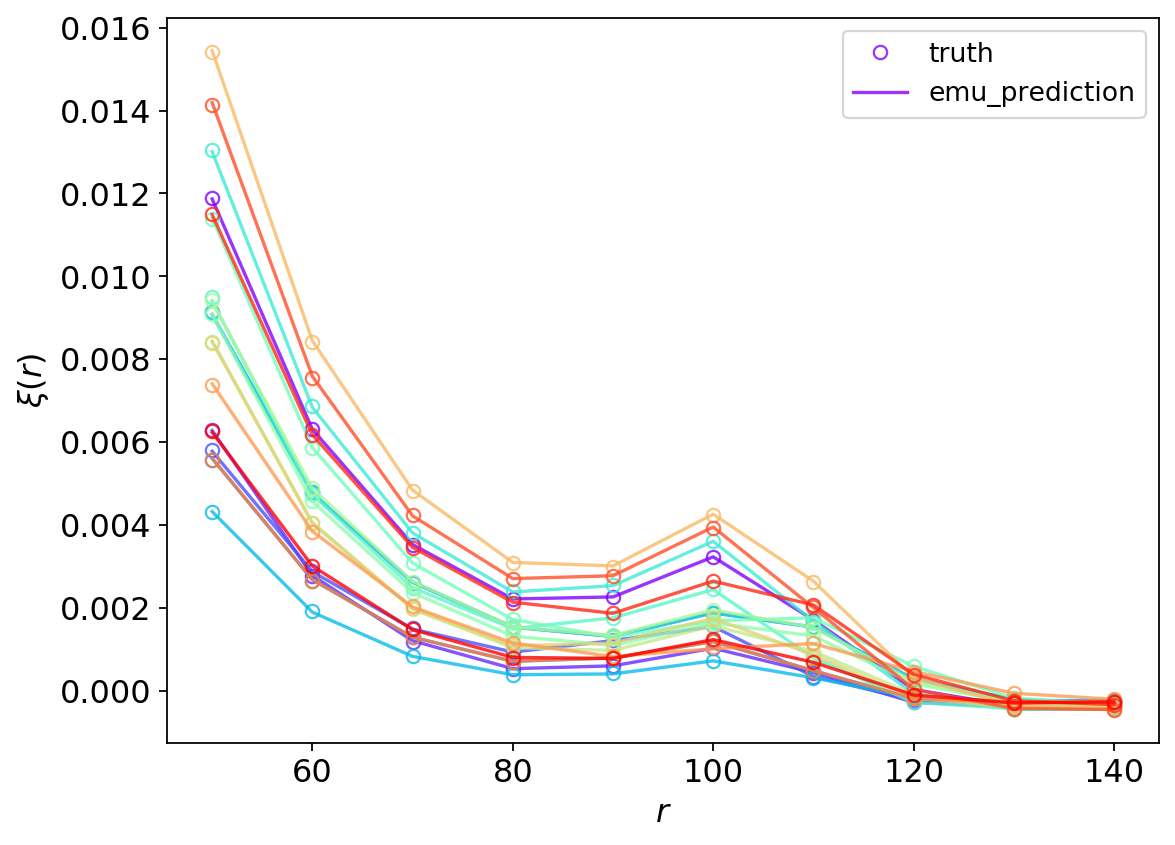

In [15]:
plt.figure(figsize=(8,6))
for i in range(n_plot):
    ys_test_plot = ys_test[idxs,:][i]
    ys_predict_plot = ys_predict[idxs][i]
    if i==0:
        label_test = 'truth'
        label_predict = 'emu_prediction'
    else:
        label_test = None
        label_predict = None
    plt.plot(r_vals[:n_values], ys_test_plot, alpha=0.8, label=label_test, marker='o', markerfacecolor='None', ls='None', color=colors[i])
    plt.plot(r_vals[:n_values], ys_predict_plot, alpha=0.8, label=label_predict, color=colors[i])
plt.xlabel('$r$')
plt.ylabel(r'$\xi(r)$')
plt.legend()

We plot the fractional error of all test set statistics:

Text(0, 0.5, 'fractional error')

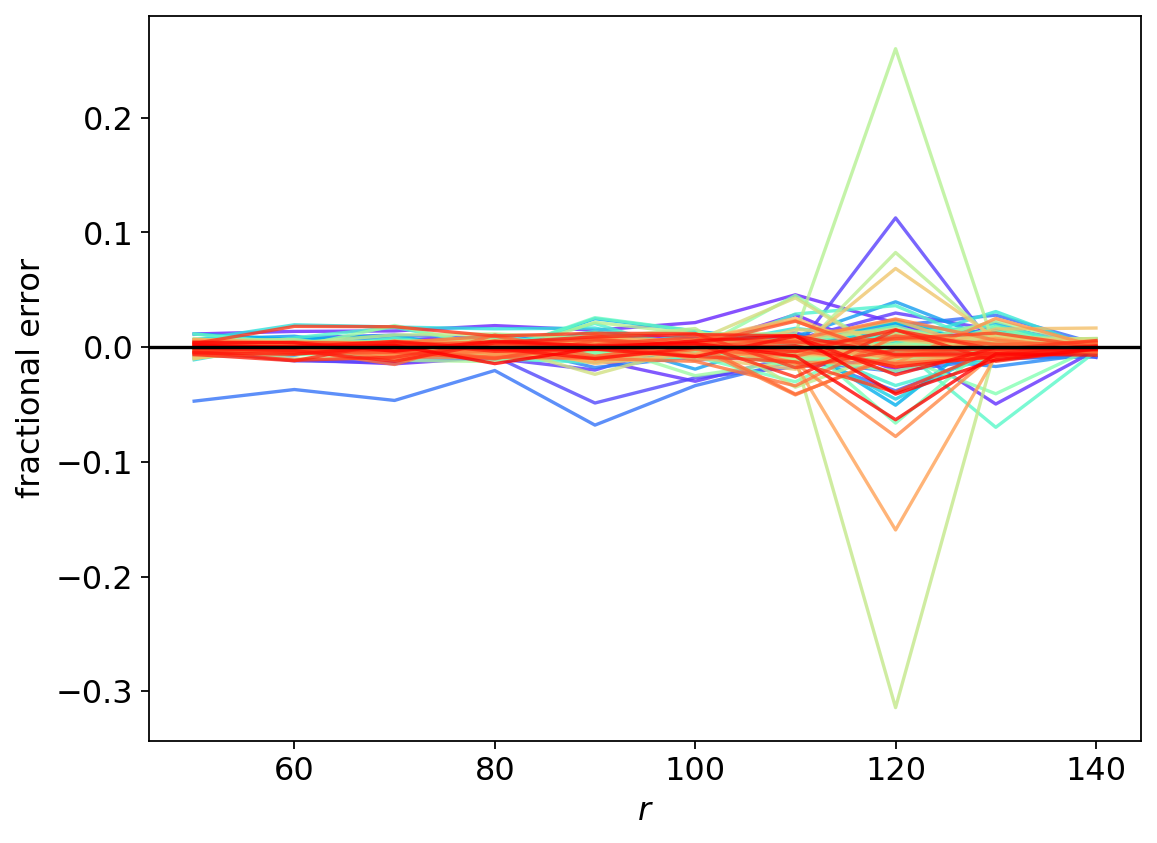

In [20]:
color_idx = np.linspace(0, 1, number_test)
colors = np.array([plt.cm.rainbow(c) for c in color_idx])
plt.figure(figsize=(8,6))
frac_errs = np.empty((number_test, n_values))
for i in range(number_test):
#     ys_test_plot = ys_test[idxs,:][i]
#     ys_predict_plot = ys_predict[idxs][i]
    ys_test_plot = ys_test[i]
    ys_predict_plot = ys_predict[i]
    frac_err = (ys_predict_plot-ys_test_plot)/ys_test_plot
    frac_errs[i] = frac_err
    plt.plot(r_vals, frac_err, alpha=0.8, color=colors[i])
plt.axhline(0.0, color='k')
plt.xlabel('$r$')
plt.ylabel(r'fractional error')

Not bad! Our emulator with 3 input parameters predicts most statistics with <2% accuracy, with just a few outliers in one of the r-bins. This r-bin is likely more difficult to emulate because it contains large range of values and both positive and negative values. 

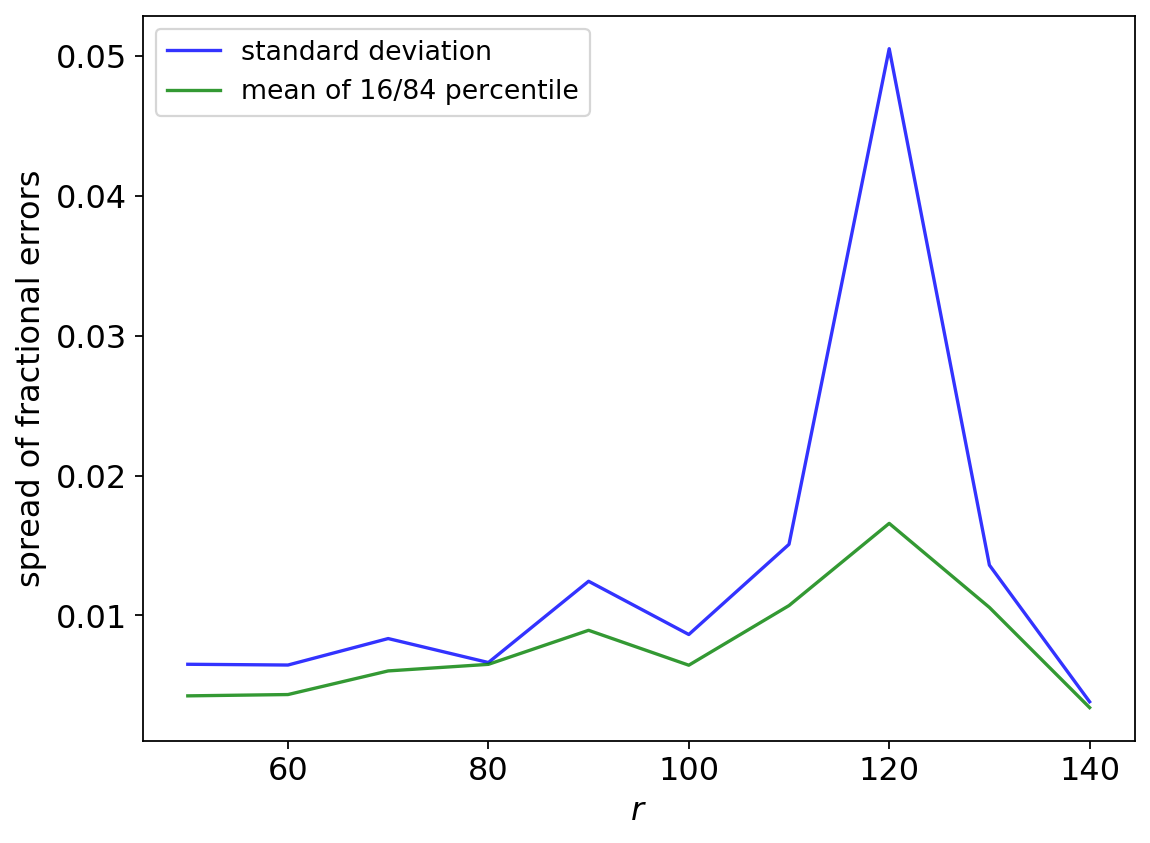

In [31]:
color_idx = np.linspace(0, 1, number_test)
colors = np.array([plt.cm.rainbow(c) for c in color_idx])
plt.figure(figsize=(8,6))
frac_errs_stdev = np.std(frac_errs, axis=0)
plt.plot(r_vals, frac_errs_stdev, alpha=0.8, color='blue', label='standard deviation')

frac_errs_p16 = np.percentile(frac_errs, 16, axis=0)
frac_errs_p84 = np.percentile(frac_errs, 84, axis=0)
frac_errs_percentile = np.mean([np.abs(frac_errs_p16), np.abs(frac_errs_p84)], axis=0)
plt.plot(r_vals, frac_errs_percentile, alpha=0.8, color='green', label="mean of 16/84 percentile")


plt.xlabel('$r$')
plt.ylabel(r'spread of fractional errors')
plt.legend()

We can see that the spike at r=120 is caused by a few outliers, as our percentile statistic is more stable than the standard deviation.

[Go back to top.](#index)